In this notebook, we evaluate the 1D-CNN ROI finder at different ADC ranges

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [2]:
wireplane = 'U'
np.random.seed(42)

def filter_signal_ADC(data, clean_data, roi_targets, adc_value, filter_by_max):
    data_wf = []
    clean_wf = []
    roi_tar = []
    for i in range(clean_data.shape[0]):
        if filter_by_max:
            if max(clean_data[i]) < adc_value or sum(clean_data[i] == 0):
                data_wf.append(data[i])
                clean_wf.append(clean_data[i])
                roi_tar.append(roi_targets[i])
        else:
            if max(clean_data[i]) > adc_value or sum(clean_data[i]) == 0:
                data_wf.append(data[i])
                clean_wf.append(clean_data[i])
                roi_tar.append(roi_targets[i])
    data_wf = np.array(data_wf)
    clean_wf = np.array(clean_wf)
    roi_tar = np.array(roi_tar)
    return data_wf, clean_wf, roi_tar

Load testing set

In [3]:
x_test = np.load('../processed_data/x_test_' + wireplane + '.npy')
y_test = np.load('../processed_data/y_test_ROI_' + wireplane + '.npy')
mean = np.load('../latest_models/mean_' + wireplane + '_nu.npy')
std = np.load('../latest_models/scale_' + wireplane + '_nu.npy')

Load trained model

In [4]:
model = load_model('../latest_models/model_' + wireplane + 'plane_nu.h5')

Evaluate model with full testing set

## Below we evaluate testing set with ADC cuts. Note all ADC at the moment are > 3

In [5]:
# need to load clean data test set meant for the AE in order to perform ADC CUTS
full_test_clean = np.load('../processed_data/y_test_AE_' + wireplane + '.npy')

In [6]:
def eval_cut(full_test_clean, x_test, adc_value, filter_by_max):
    full_test = x_test
    if filter_by_max:
        test_, clean_, y_test_ =  filter_signal_ADC(full_test, full_test_clean, y_test, adc_value, True)
    else:
        test_, clean_, y_test_ =  filter_signal_ADC(full_test, full_test_clean, y_test, adc_value, False)
    x_test_scaled = (test_-mean)/std
    all_infer = model.predict(x_test_scaled, batch_size=4096)
    all_y_test = y_test_
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(all_y_test, all_infer)

    fpr_keras, tpr_keras, thresholds_keras = roc_curve(all_y_test, all_infer)
    plt.plot(fpr_keras, tpr_keras, label='auc: ' + str(round(auc(fpr_keras, tpr_keras), 3)))
    if filter_by_max:
        plt.title("ROC Curve - Test Dataset Plane " + wireplane + ' (ADC < ' + str(adc_value) + ')' )
    else:
        plt.title("ROC Curve - Test Dataset Plane " + wireplane + ' (ADC > ' + str(adc_value) + ')' )
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc='center')
    plt.show()

25/25 [==============================] - 3s 2ms/step


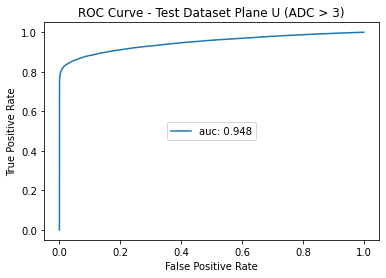

24/24 [==============================] - 0s 12ms/step


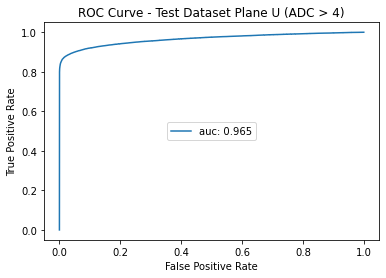

24/24 [==============================] - 0s 12ms/step


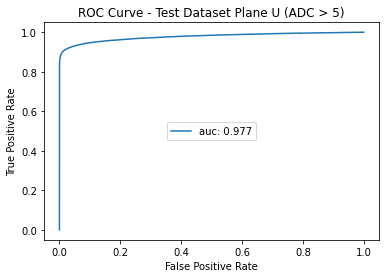

23/23 [==============================] - 0s 13ms/step


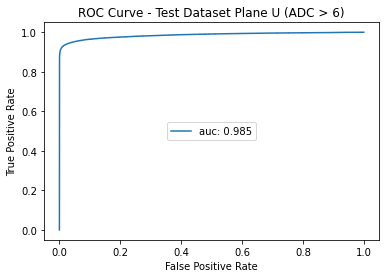

23/23 [==============================] - 0s 4ms/step


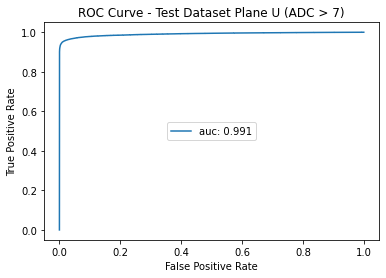

22/22 [==============================] - 0s 9ms/step


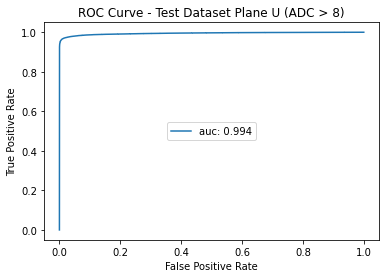

22/22 [==============================] - 0s 4ms/step


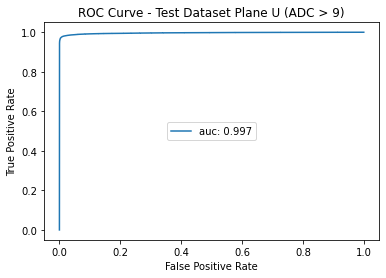

22/22 [==============================] - 0s 15ms/step


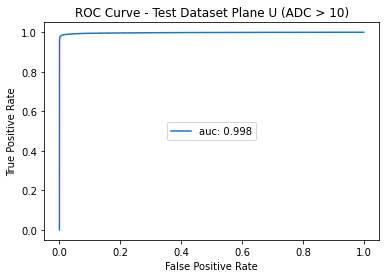

21/21 [==============================] - 0s 5ms/step


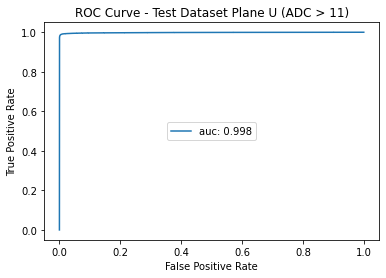

21/21 [==============================] - 0s 15ms/step


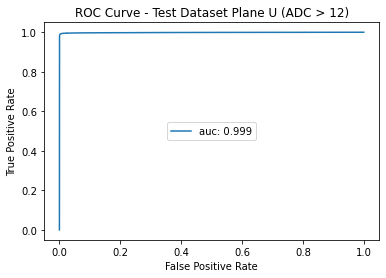

21/21 [==============================] - 0s 5ms/step


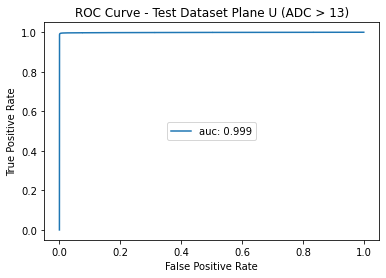

21/21 [==============================] - 0s 12ms/step


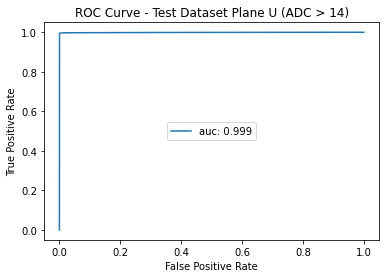

21/21 [==============================] - 0s 5ms/step


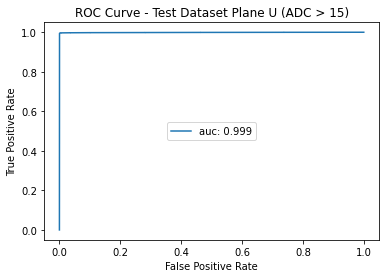

21/21 [==============================] - 0s 11ms/step


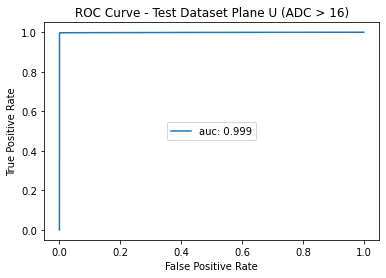

20/20 [==============================] - 0s 5ms/step


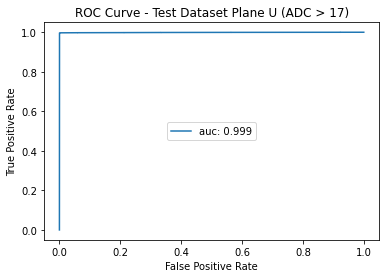

20/20 [==============================] - 0s 15ms/step


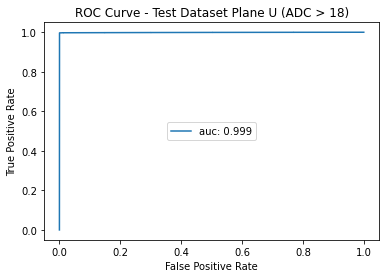

20/20 [==============================] - 0s 13ms/step


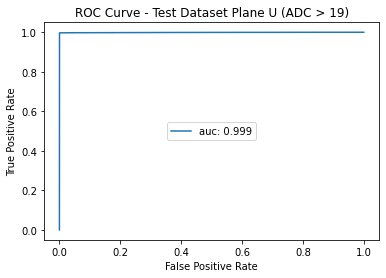

In [7]:
for i in range(3, 20):
    eval_cut(full_test_clean, x_test, i, False)